In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.datasets import fetch_openml 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [104]:
def load_dataset(path,index_col='Id'):
    return  pd.read_csv(path,index_col=index_col) ## setting the index to be the Id
df_train = load_dataset('../train.csv')
columns = list(df_train.columns)[:-1]

In [196]:
# Alley -> so many NaN values
# Street -> just one value repeated alot.
# LandContour -> so many in LVl.
# Utilities -> so many values for one category.
# LandSlope -> so many values for one category.
# Condition1,Condition2 -> so many values for one category.
# GarageYrBlt there is a positive correlation between it and YrBuilt.
# GarageCars there is a positive correlation between it and GarageArea.
drop_columns = set(['Alley','PoolQC','Fence','SaleType','OpenPorchSF','GarageYrBlt','YrSold','PoolArea','Street','LandContour','Utilities','LandSlope','Condition1','Condition2','SaleCondition','EnclosedPorch','3SsnPorch','SaleType','MoSold','HalfBath','RoofMatl','GarageCars','WoodDeckSF','EnclosedPorch','Functional','FireplaceQu','PavedDrive','MSZoning','LotConfig','LotFrontage','LotArea','OverallCond','MasVnrType','MiscFeature','ScreenPorch','MiscVal','BsmtHalfBath','LowQualFinSF','BsmtUnfSF','BsmtExposure','Fireplaces','Exterior2nd','GarageCond','KitchenAbvGr','BedroomAbvGr','BsmtFullBath','BsmtFinType2','BsmtFinSF2','ExterCond','BsmtFinSF1','BsmtFinType1','BsmtCond','YearRemodAdd','MasVnrArea','GarageFinish','GarageQual',
'LotShape','Exterior1st','MSSubClass','TotalBsmtSF'])

In [197]:
def wrangle_data(df,columns_trim=[],trim_end=0.95):
    try:
        df = df.drop(columns=drop_columns)
        df = df[ df['SalePrice'] < df['SalePrice'].quantile(0.95)]
        df = df.dropna()
        
        for col_tri in columns_trim: ## removing the outliers of the features data
            df = df[ df[col_tri] < df[col_tri].quantile(trim_end)]
        #df['allarea'] = df.apply(lambda row: row['1stFlrSF'] + row['2ndFlrSF'],axis=1) ## combining the two features togther
        df.drop(columns=['1stFlrSF','2ndFlrSF'],inplace=True)
        return df
    except (KeyError, AttributeError) as e  :
        return wrangle_data(df.drop(columns=drop_columns))
        
df_train_dropped = wrangle_data(df_train)
df_train_dropped

,Neighborhood,BldgType,HouseStyle,OverallQual,YearBuilt,RoofStyle,ExterQual,Foundation,BsmtQual,Heating,HeatingQC,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageType,GarageArea,SalePrice
Id,,,,,,,,,,,,,,,,,,,,
1,CollgCr,1Fam,2Story,7,2003,Gable,Gd,PConc,Gd,GasA,Ex,Y,SBrkr,1710,2,Gd,8,Attchd,548,208500
2,Veenker,1Fam,1Story,6,1976,Gable,TA,CBlock,Gd,GasA,Ex,Y,SBrkr,1262,2,TA,6,Attchd,460,181500
3,CollgCr,1Fam,2Story,7,2001,Gable,Gd,PConc,Gd,GasA,Ex,Y,SBrkr,1786,2,Gd,6,Attchd,608,223500
4,Crawfor,1Fam,2Story,7,1915,Gable,TA,BrkTil,TA,GasA,Gd,Y,SBrkr,1717,1,Gd,7,Detchd,642,140000
5,NoRidge,1Fam,2Story,8,2000,Gable,Gd,PConc,Gd,GasA,Ex,Y,SBrkr,2198,2,Gd,9,Attchd,836,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,Gilbert,1Fam,2Story,6,1999,Gable,TA,PConc,Gd,GasA,Ex,Y,SBrkr,1647,2,TA,7,Attchd,460,175000
1457,NWAmes,1Fam,1Story,6,1978,Gable,TA,CBlock,Gd,GasA,TA,Y,SBrkr,2073,2,TA,7,Attchd,500,210000
1458,Crawfor,1Fam,2Story,7,1941,Gable,Ex,Stone,TA,GasA,Ex,Y,SBrkr,2340,2,Gd,9,Attchd,252,266500


In [198]:
df_train_dropped.select_dtypes(include=[np.number])

,OverallQual,YearBuilt,GrLivArea,FullBath,TotRmsAbvGrd,GarageArea,SalePrice
Id,,,,,,,
1,7,2003,1710,2,8,548,208500
2,6,1976,1262,2,6,460,181500
3,7,2001,1786,2,6,608,223500
4,7,1915,1717,1,7,642,140000
5,8,2000,2198,2,9,836,250000
...,...,...,...,...,...,...,...
1456,6,1999,1647,2,7,460,175000
1457,6,1978,2073,2,7,500,210000
1458,7,1941,2340,2,9,252,266500


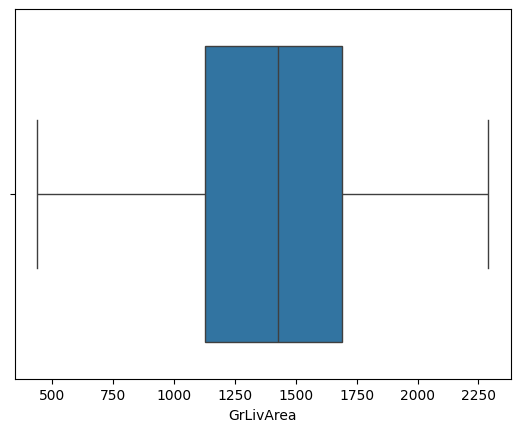

In [179]:
sns.boxplot(x='GrLivArea',data=df_train_dropped);

In [199]:
X = df_train_dropped.drop(columns=['SalePrice'])
y = df_train_dropped['SalePrice']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [200]:
ordinal_attr = set(['BsmtQual','KitchenQual','ExterQual','BsmtQual','HeatingQC'])
cat_attr = set(list(X.select_dtypes(include=[object]).columns))
cat_attr = list(set([item for item in cat_attr if item not in ordinal_attr ]))
nums_attr = list(set(list(X.select_dtypes(include=[np.number]).columns)))
ordinal_attr = list(ordinal_attr)

<Axes: xlabel='ExterQual', ylabel='SalePrice'>

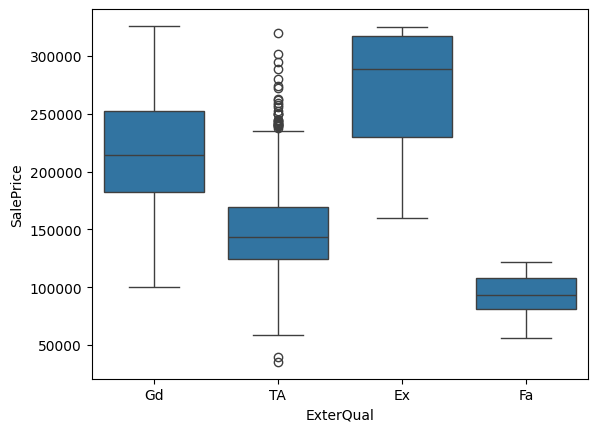

In [189]:
sns.boxplot(x='ExterQual',y='SalePrice',data=df_train_dropped)

In [201]:
cat_pipeline = OneHotEncoder(handle_unknown='infrequent_if_exist')
ordinal_pipe = make_pipeline(OrdinalEncoder(),StandardScaler())

num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler())
column_transformer = ColumnTransformer(  ## for making a parallel pipeline, one for categorical and one for numerical data.
    [('num',num_pipeline,nums_attr),
    ('cat',cat_pipeline,cat_attr),
    ('ordinal',ordinal_pipe,ordinal_attr)
    ]
)
model = make_pipeline(column_transformer,LinearRegression())
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['OverallQual', 'GrLivArea',
                                                   'GarageArea', 'TotRmsAbvGrd',
                                                   'FullBath', 'YearBuilt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['CentralAir', 'BldgType',
                                                   'Foundation', 'Heating',
                                                   'Electrical', 'Neighborhood',
                                                   'GarageType', 'HouseStyle',
                                                   'RoofStyle']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['KitchenQual', 'BsmtQual',
                                                   'ExterQual',
                                                   'HeatingQC'])])),
                ('linearregression', LinearRegression())])

In [202]:
r2_score(y_test,model.predict(X_test))

0.8310146972646263

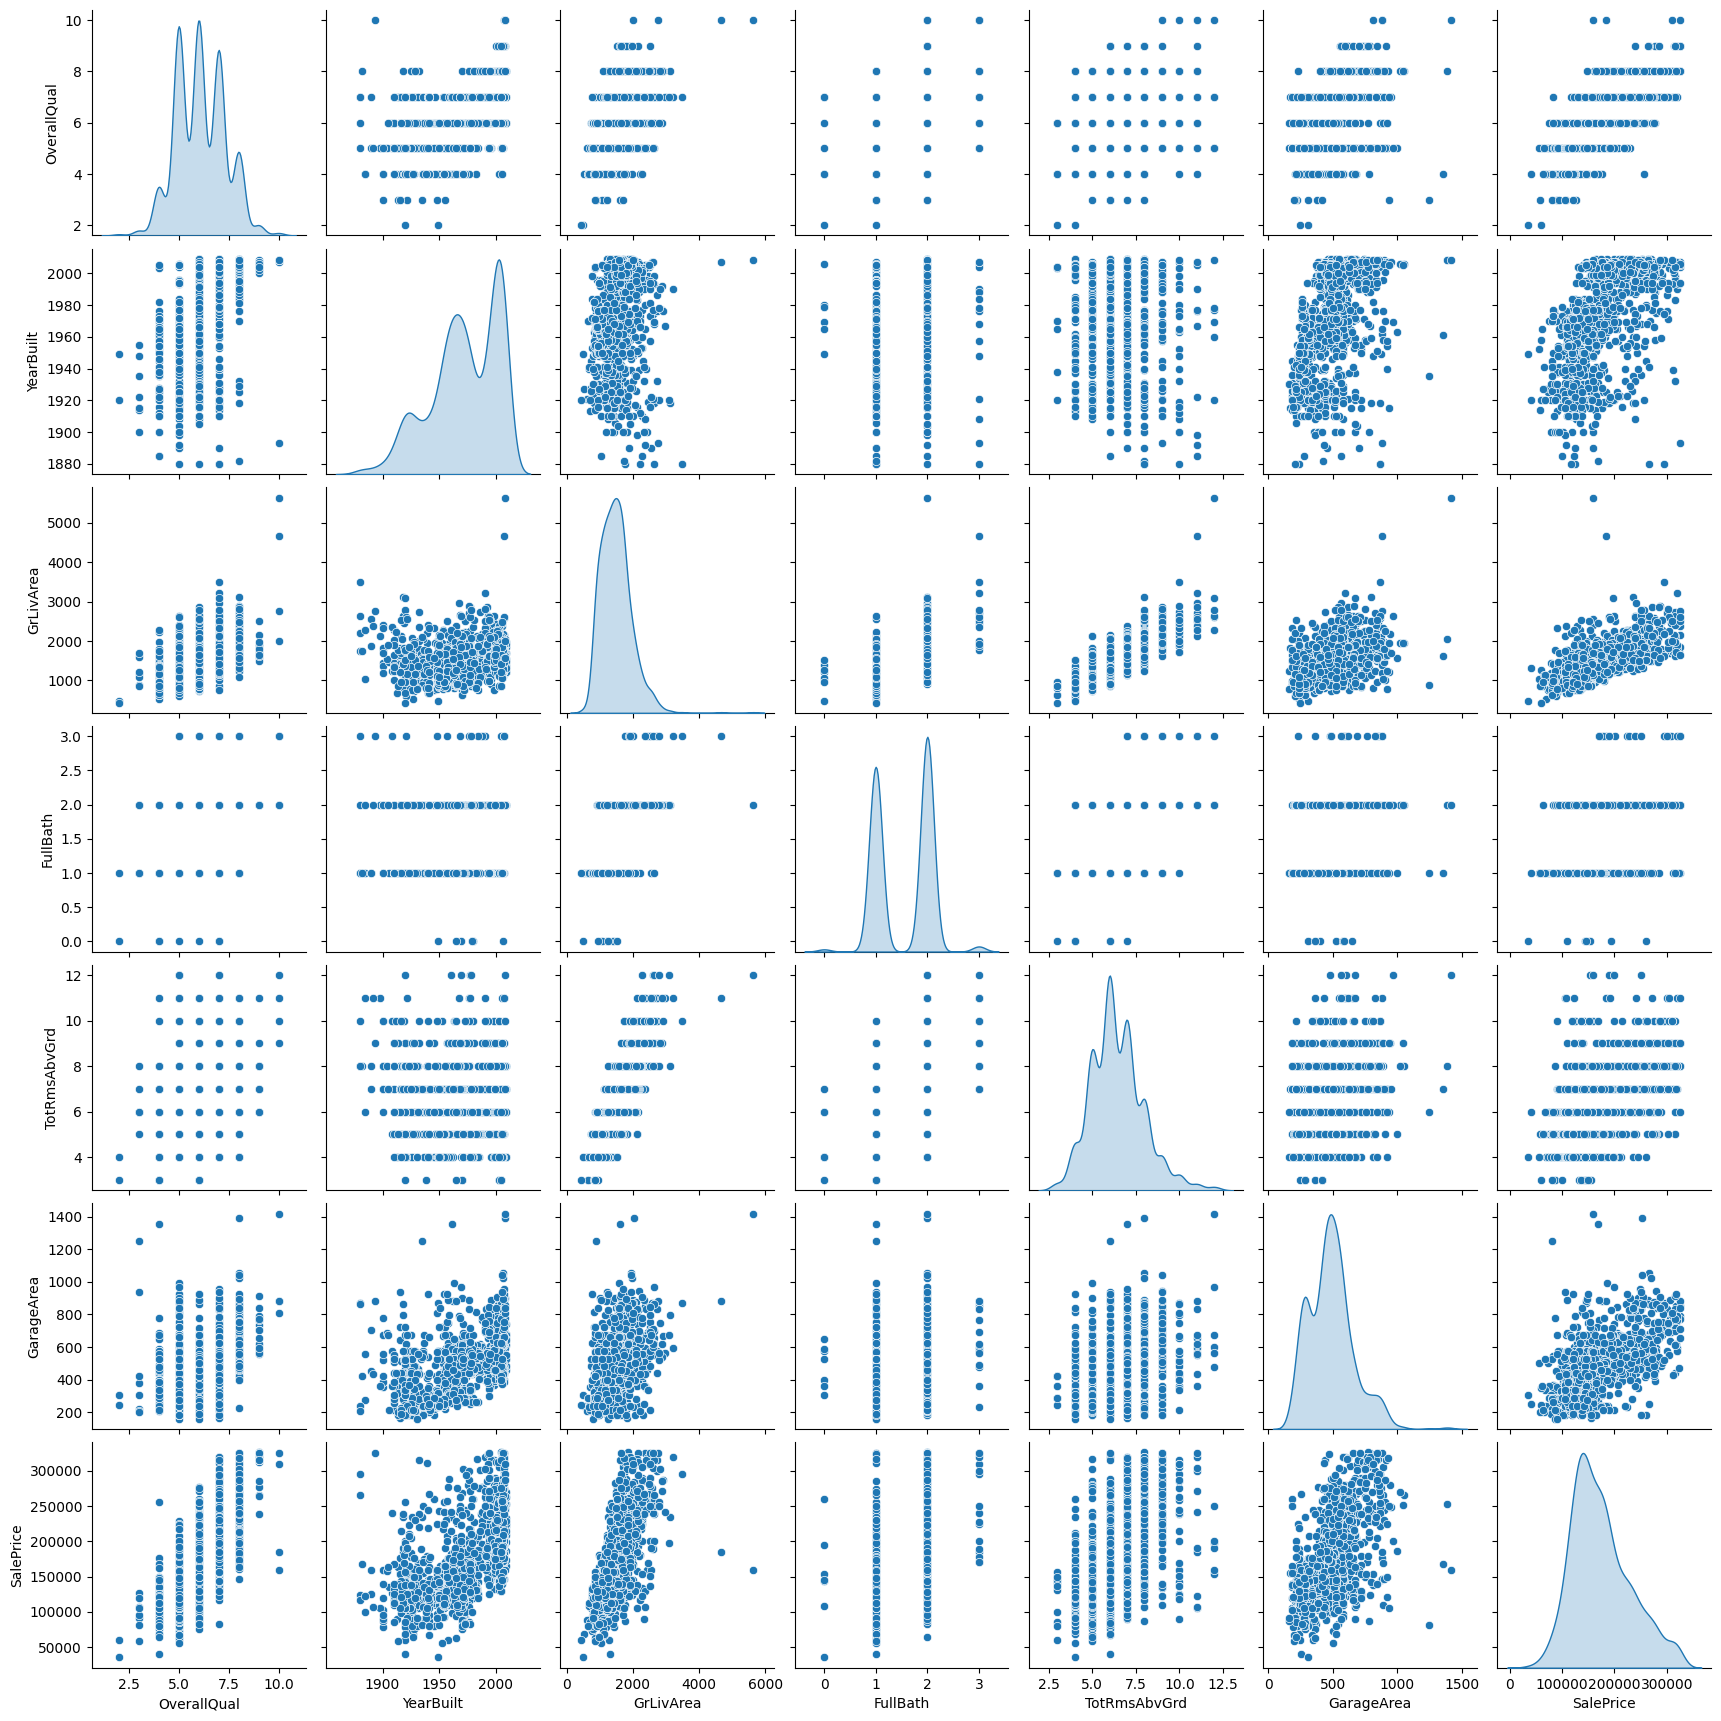

In [203]:
sns.pairplot(data=df_train_dropped, diag_kind='kde')

In [210]:
from sklearn.model_selection import cross_val_score,KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv = cross_val_score(model,X,y,cv=kf)
cv

c:\Users\hp\Desktop\Mans1611\ML\Linear Regression\DEPI\lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\hp\Desktop\Mans1611\ML\Linear Regression\DEPI\lib\site-packages\sklearn\metrics\_scorer.py", line 143, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
  File "c:\Users\hp\Desktop\Mans1611\ML\Linear Regression\DEPI\lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "c:\Users\hp\Desktop\Mans1611\ML\Linear Regression\DEPI\lib\site-packages\sklearn\pipeline.py", line 1000, in score
    Xt = transform.transform(Xt)
  File "c:\Users\hp\Desktop\Mans1611\ML\Linear Regression\DEPI\lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Use

array([0.83101466, 0.73949742, 0.83715985, 0.79702981,        nan])

LinearRegression()

In [229]:
from sklearn.svm import SVR

cat_pipeline = OneHotEncoder(handle_unknown='infrequent_if_exist')
ordinal_pipe = make_pipeline(OrdinalEncoder(),StandardScaler())

num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler())
column_transformer = ColumnTransformer(  ## for making a parallel pipeline, one for categorical and one for numerical data.
    [('num',num_pipeline,nums_attr),
    ('cat',cat_pipeline,cat_attr),
    ('ordinal',ordinal_pipe,ordinal_attr)
    ]
)
svr_model = make_pipeline(column_transformer, SVR(kernel='linear'))
svr_model.fit_transform(X_train,y_train)


AttributeError: This 'Pipeline' has no attribute 'fit_transform'

In [228]:
r2_score(y_test,svr_model.predict(X_test))

0.0018223103979315702

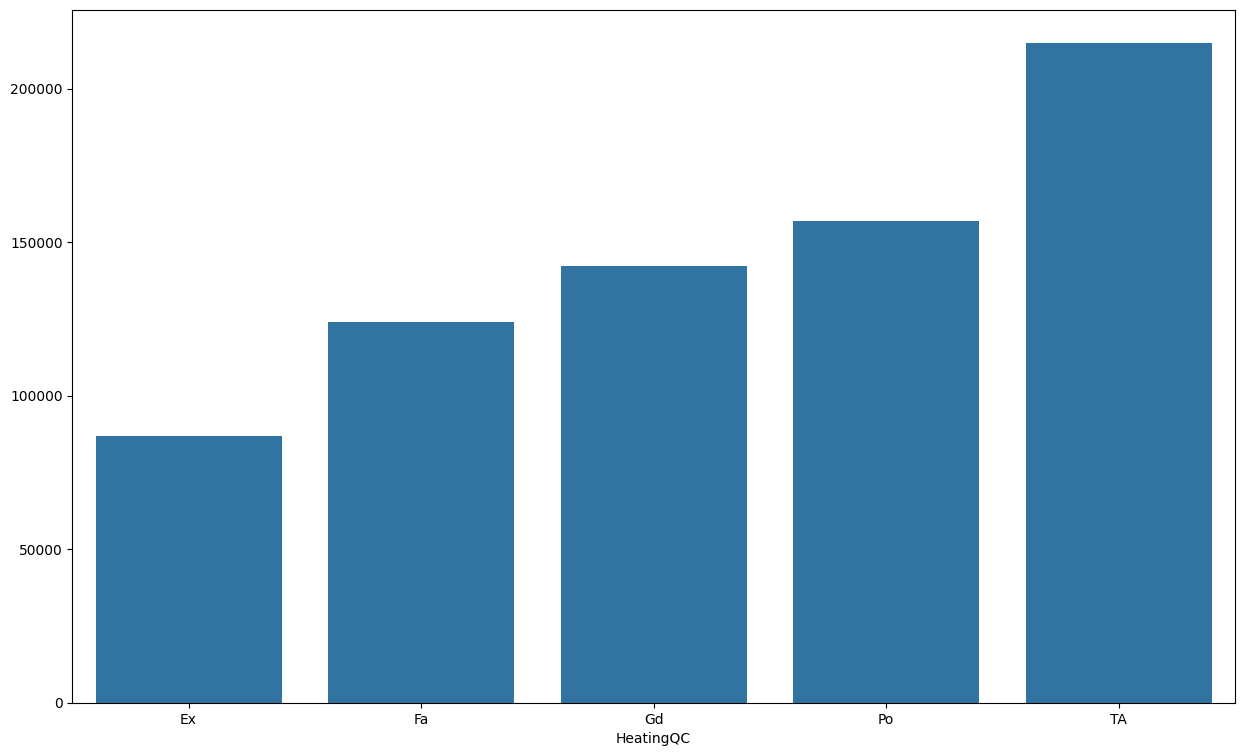

In [47]:
def plot_shape_bar(feature,target):
    fig = plt.figure(figsize=(15,9))
    agg_year_built = df_train[[feature,target]].groupby(feature).agg(['mean'])
    sns.barplot(x=agg_year_built.index,y=sorted(agg_year_built[target]['mean']))
plot_shape_bar('HeatingQC','SalePrice')

In [18]:
def column_details(column_name):
    print(df_train[column_name].unique())
    print(df_train[column_name].value_counts())
#column_details('BsmtFinType2')

In [17]:
model[];

In [ ]:
perc = df_train[(df_train['1stFlrSF'] > df_train['1stFlrSF'].quantile(0.05)) & (df_train['1stFlrSF'] < df_train['1stFlrSF'].quantile(0.95))]
print(perc[['1stFlrSF','SalePrice']].corr())
plt.scatter(x=perc['BedroomAbvGr'],y=perc['SalePrice'])

In [ ]:
def plot_shape_line(feature,target):
    agg_year_built = df_train[[feature,target]].groupby(feature).agg(['mean'])
    sns.lineplot(x=agg_year_built.index,y=agg_year_built[target]['mean'])
plot_shape_line('FullBath','SalePrice')

In [ ]:
df_train_dropped[['MasVnrArea',]]

In [ ]:
def plot_shape_scatter(feature,target):
    fig = plt.figure(figsize=(12,9))
    agg_year_built = plt.scatter(x=df_train[feature],y=df_train[target])
plot_shape_scatter('MasVnrArea','SalePrice')

In [ ]:
def plot_shape_bar(feature,target):
    fig = plt.figure(figsize=(15,9))
    agg_year_built = df_train[[feature,target]].groupby(feature).agg(['mean'])
    sns.barplot(x=agg_year_built.index,y=sorted(agg_year_built[target]['mean']))
plot_shape_bar('ExterQual','SalePrice')

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
selector.fit(df_train.select_dtypes(include=[np.number]).drop(columns=['SalePrice']), df_train['SalePrice'])
important_features = df_train.drop(columns=['SalePrice']).columns[selector.get_support()]
df = df_train[important_features]
df

In [ ]:
def build_model(features,target):
    model = LinearRegression()
    return Pipeline([
        ('SimpleImputer',SimpleImputer(strategy='mean')),
        ('multi linear regression',model),
    ])